In [1]:
import pandas as pd
import numpy as np
from vowpalwabbit import pyvw
import matplotlib.pyplot as plt
import math
import slates
import os
def setup_outcomes():
    return {('Mac', 'wifi', 'CA'): [], ('Mac', 'wifi', 'US'): [], ('Mac', 'wired', 'CA'): [], ('Mac', 'wired', 'US'): [], ('Windows', 'wifi', 'CA'): [], ('Windows', 'wifi', 'US'): [], ('Windows', 'wired', 'CA'): [], ('Windows', 'wired', 'US'): []}

In [13]:
GROUND_TRUTH_DATASET = "data/seed7/df_all_8_6_4_0,1.csv"
TEST_DATASETS = {
#     "8_6_4_0,2" : "data/seed7/df_all_8_6_4_0,2.csv",
    "8_6_4_0,1" : "data/seed7/df_all_8_6_4_0,1.csv",
#     "8_6_4_0,01" : "data/seed7/df_all_8_6_4_0,01.csv",
#     "8_6_4_0,001" : "data/seed7/df_all_8_6_4_0,001.csv",
#     "8_6_4_0,0001" : "data/seed7/df_all_8_6_4_0,0001.csv",
}

In [3]:
contexts_to_choose_from = [
    ('Mac','wifi','CA'),
    ('Mac','wifi','US'),
    ('Mac','wired','CA'),
    ('Mac','wired','US'),
    ('Windows','wifi','CA'),
    ('Windows','wifi','US'),
    ('Windows','wired','CA'),
    ('Windows','wired','US')
]


In [4]:
common_args = "--quiet --cb_type mtr --epsilon 0.2 --first_only"
# slates_args = common_args + " --ccb_explore_adf --coin --slate --interactions UA US SA UAS --l1 1e-6 --clip_p 0.2 --ignore_linear U A S"
slates_args = common_args + " --ccb_explore_adf --coin --interactions UA UUA UUUA" 
cb_args = common_args + " --cb_explore_adf --coin --interactions UA UUA UUUA"
num_iter = 250000

# 1 understand if combinatorial works
# - It must converge
# 2 
# - Slates must converge faster
# - FInd optimal policy that converged fastest

# learning rate 0.001 

In [5]:
test_configs = {}
for name in TEST_DATASETS:
    test_configs[name] = {}
    df = pd.read_csv(TEST_DATASETS[name])
    test_configs[name]["data"] = df
    test_configs[name]["rewards"] = pd.DataFrame(df.groupby(['platform', 'network', 'country','x','y','z'])['reward'].unique()).reset_index()
    test_configs[name]["x"] = sorted(df["x"].unique())
    test_configs[name]["y"] = sorted(df["y"].unique())
    test_configs[name]["z"] = sorted(df["z"].unique())
    test_configs[name]["x_actions"] = ["x="+str(a) for a in test_configs[name]["x"]]
    test_configs[name]["y_actions"] = ["y="+str(a) for a in test_configs[name]["y"]]
    test_configs[name]["z_actions"] = ["z="+str(a) for a in test_configs[name]["z"]]
    
    all_string_actions, all_actions = slates.combine_float_actions_categorical(test_configs[name]["x"],test_configs[name]["y"],test_configs[name]["z"])
    test_configs[name]["all_string_actions"] = all_string_actions
    test_configs[name]["all_actions"] = all_actions


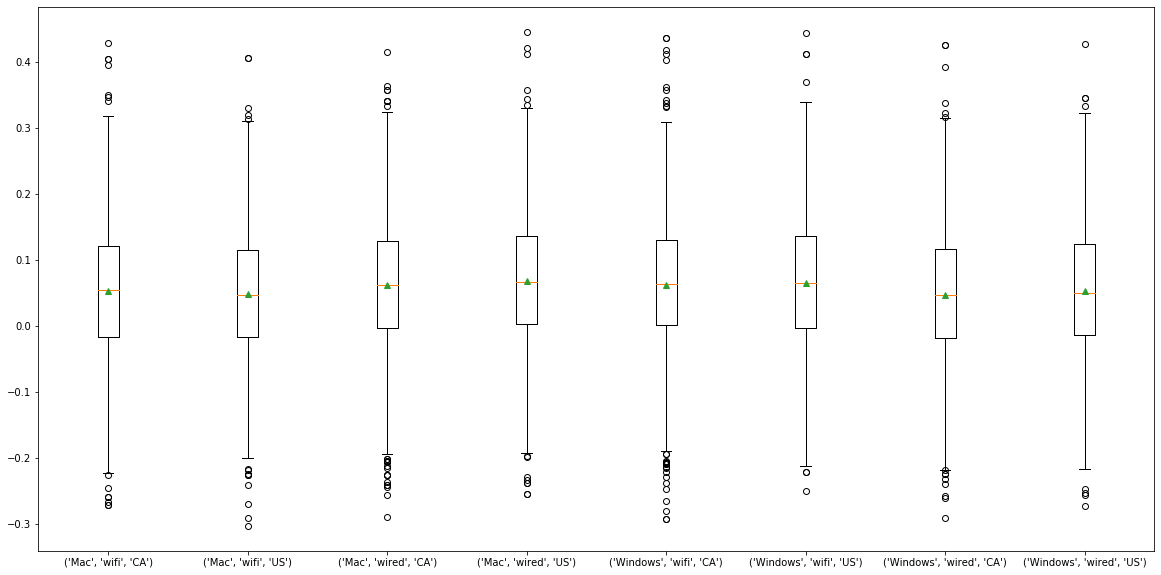

In [14]:
ground_truth_df = pd.read_csv(GROUND_TRUTH_DATASET)
ground_truth_rewards_df = pd.DataFrame(ground_truth_df.groupby(['platform', 'network', 'country','x','y','z'])['reward'].unique()).reset_index()

min_reward = {}
min_actions = {}

plt.figure(figsize=(20, 10))

grps_context = ground_truth_df.groupby(['platform', 'network', 'country'])
for i, context in enumerate(grps_context.groups.keys()):
    df_temp = grps_context.get_group(context)
    if context not in min_reward.keys():
        min_reward[context] = {}
    grps_action = df_temp.groupby(['x', 'y', 'z'])
    for action in grps_action.groups.keys():
        df_temp2 = grps_action.get_group(action)
        min_reward[context][action] = np.mean(df_temp2['reward'])
        
    min_reward_action = min(min_reward[context], key=min_reward[context].get)
    min_actions[context] = min_reward_action
    plt.boxplot(grps_action.get_group(min_reward_action)["reward"], positions=[i], labels=["{}".format(context)], showmeans=True)
plt.show()


Number of actions 192


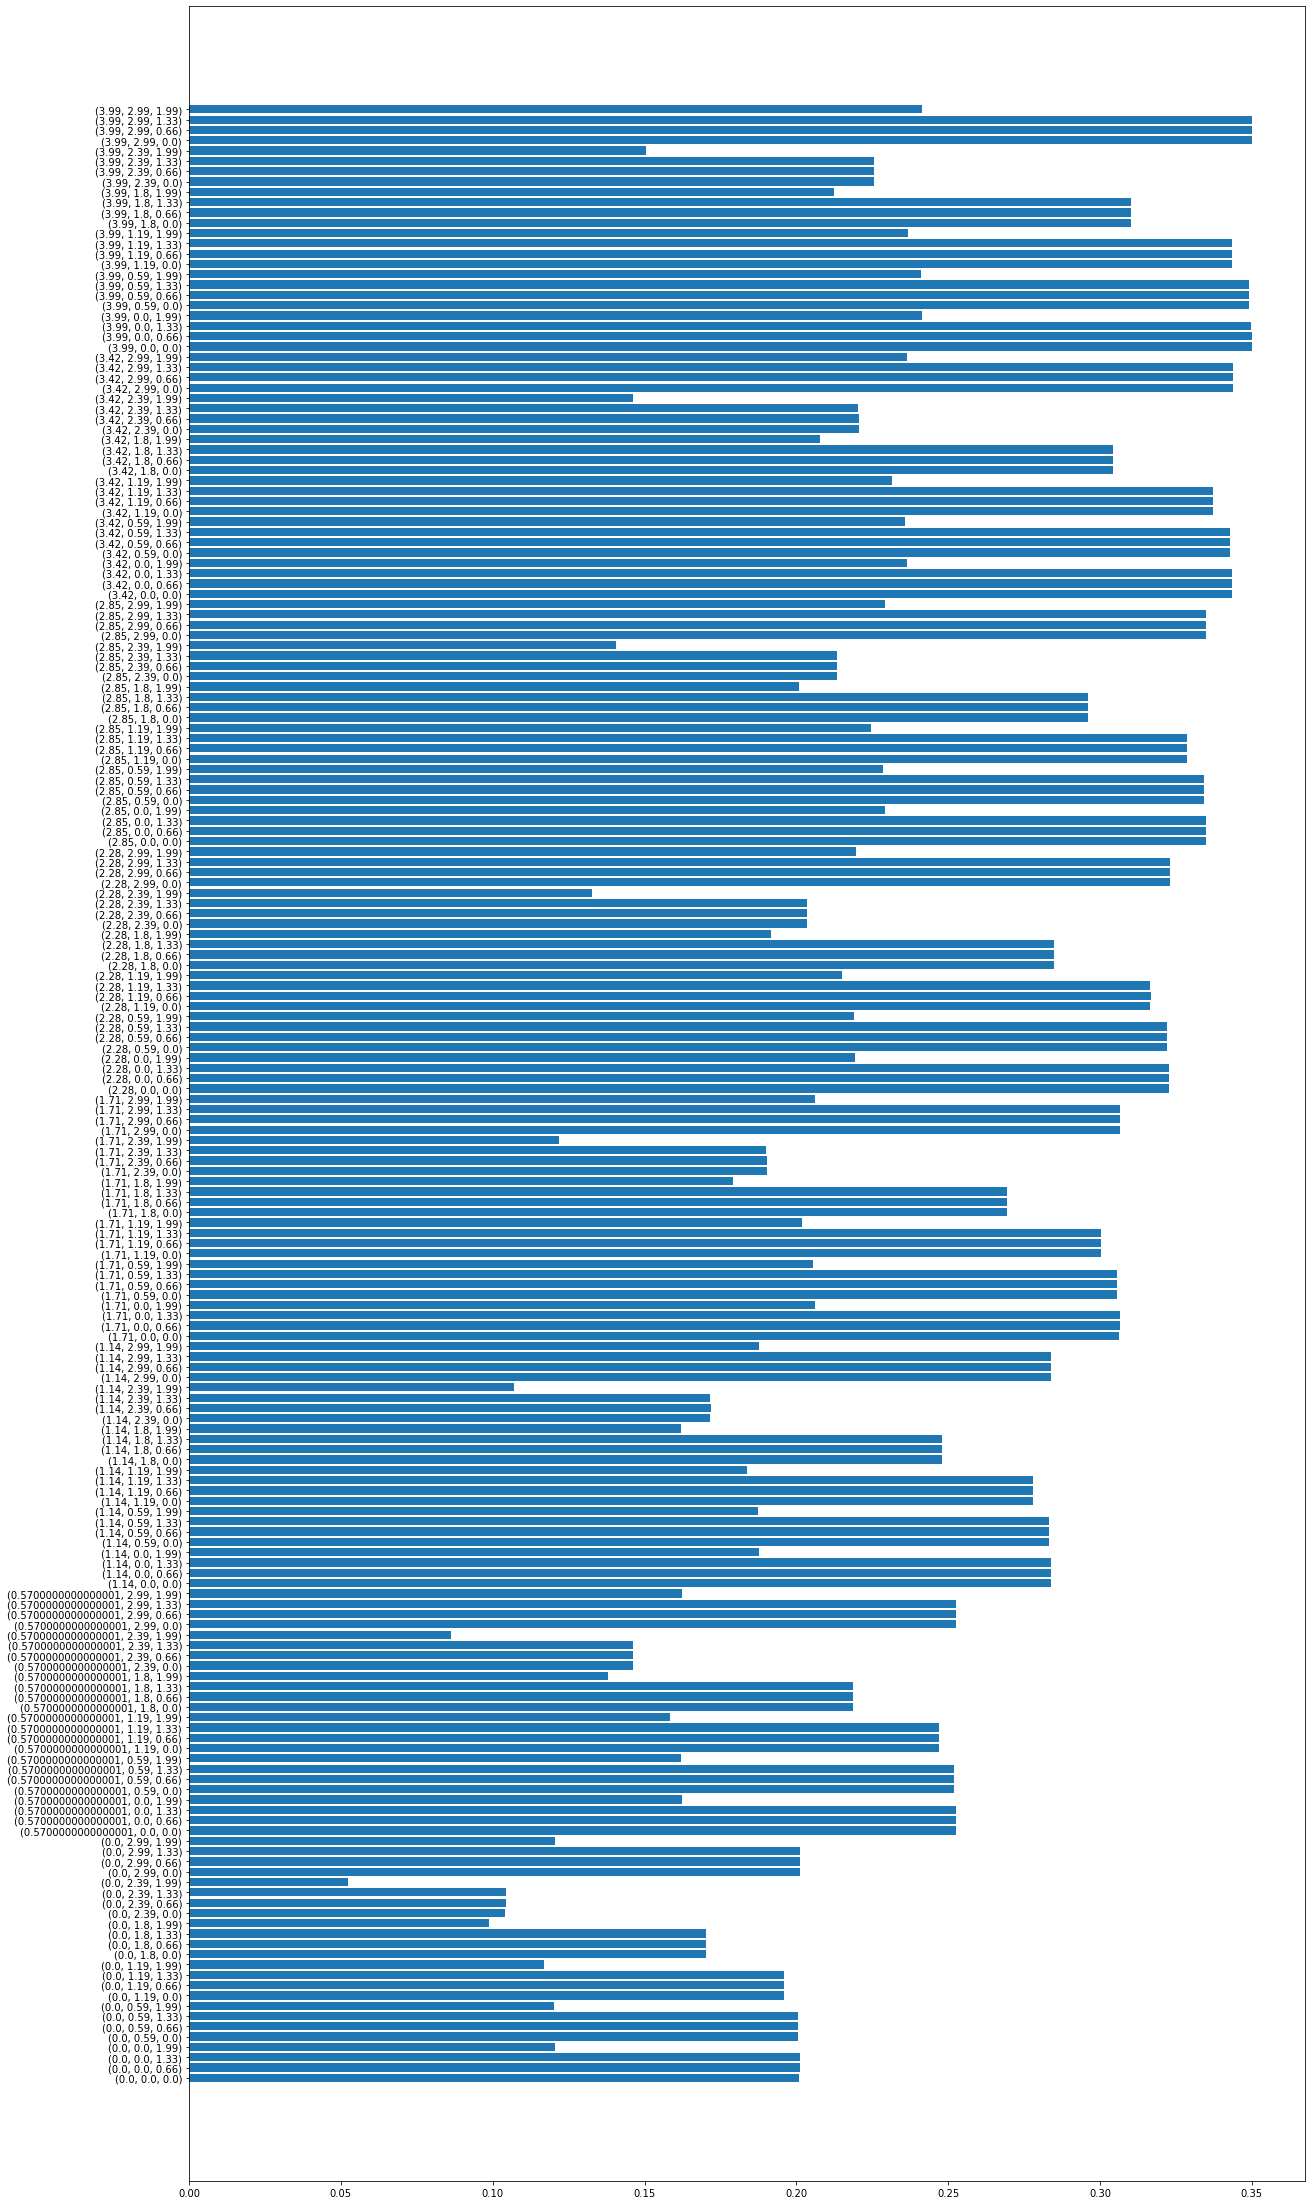

In [7]:
plt.figure(figsize=(20,40))
data = min_reward[('Windows', 'wired', 'US')]
x = data.keys()
average_values = data.values()
print("Number of actions", len(average_values))
x_pos = [i for i, _ in enumerate(x)]
plt.yticks(x_pos, x)

plt.barh(x_pos, average_values)
plt.show()

In [8]:
min_actions

{('Mac', 'wifi', 'CA'): (2.28, 2.39, 1.99),
 ('Mac', 'wifi', 'US'): (1.14, 2.39, 1.99),
 ('Mac', 'wired', 'CA'): (1.71, 2.39, 1.99),
 ('Mac', 'wired', 'US'): (1.14, 2.39, 1.99),
 ('Windows', 'wifi', 'CA'): (1.14, 1.8, 1.99),
 ('Windows', 'wifi', 'US'): (0.0, 2.39, 1.99),
 ('Windows', 'wired', 'CA'): (1.14, 2.39, 1.99),
 ('Windows', 'wired', 'US'): (0.0, 2.39, 1.99)}

In [9]:
# min_actions[('Mac', 'wifi', 'CA')]

In [10]:
def optimal_policy_sample(context, action):
    row_index = ground_truth_rewards_df.index[(ground_truth_rewards_df['platform'] == context[0])
                                           & (ground_truth_rewards_df['network'] == context[1])
                                           & (ground_truth_rewards_df['country'] == context[2])
                                           & (ground_truth_rewards_df['x'] == action[0])
                                           & (ground_truth_rewards_df['y'] == action[1])
                                           & (ground_truth_rewards_df['z'] == action[2])
                                          ]
    possible_rewards = ground_truth_rewards_df.iloc[row_index[0]]["reward"]
    return np.random.choice(possible_rewards)

def optimal_policy_median(context, action):
    row_index = ground_truth_rewards_df.index[(ground_truth_rewards_df['platform'] == context[0])
                                           & (ground_truth_rewards_df['network'] == context[1])
                                           & (ground_truth_rewards_df['country'] == context[2])
                                           & (ground_truth_rewards_df['x'] == action[0])
                                           & (ground_truth_rewards_df['y'] == action[1])
                                           & (ground_truth_rewards_df['z'] == action[2])
                                          ]
    possible_rewards = ground_truth_rewards_df.iloc[row_index[0]]["reward"]
    return np.median(possible_rewards)


# Slates

In [11]:
trajectory_strings = []
for name in test_configs:
    test_configs[name]["outcomes"] = setup_outcomes()
    test_configs[name]["x_outcomes"] = setup_outcomes()
    test_configs[name]["y_outcomes"] = setup_outcomes()
    test_configs[name]["z_outcomes"] = setup_outcomes()
    
    model = pyvw.vw(slates_args)

    df = test_configs[name]["data"]
    rewards = test_configs[name]["rewards"]

    for i in range(num_iter):
        if i % 1000 == 0:
            print(i)
        platform,network,country = contexts_to_choose_from[np.random.choice(len(contexts_to_choose_from))]
        
        shared_context = "platform={} region={} connection={}".format(platform, country, network)
        examples = slates.create_slates_example(model, shared_context, [test_configs[name]["x_actions"], test_configs[name]["y_actions"], test_configs[name]["z_actions"]])
        pred = slates.slate_pred_conv(model.predict(examples, prediction_type=pyvw.pylibvw.vw.pDECISION_SCORES))
        model.finish_example(examples)
        
#         print(pred)
        
        # Choose the slot to samlpe
        chosen_slot = np.random.choice(len(pred))
        slot_to_sample = pred[chosen_slot]
        # Sample an index from this slot
        index = slates.sample_index(slot_to_sample)
        # Swap sampled action if it was not the 0th item.
        if index != 0:
            slot_to_sample[0], slot_to_sample[index] = slot_to_sample[index], slot_to_sample[0]
        # Assign the potentially modified slot back into the prediction
        pred[chosen_slot] = slot_to_sample
        
        exploit_a = 0
        for pred_a in pred:
            all_probs = [x[1] for x in pred_a]
            if pred_a[0][0] == max(pred_a,key=lambda x:x[1])[0] and not(all_probs[1:] == all_probs[:-1]):
                exploit_a +=1

        chosen_x = test_configs[name]["x"][pred[0][0][0]]
        chosen_y = test_configs[name]["y"][pred[1][0][0]]
        chosen_z = test_configs[name]["z"][pred[2][0][0]]
        
        # "['Windows', 'wired', 'CA']","(3.79, 0.11, 1.05)",8
        trajectory_strings.append(f"\"('{platform}', '{network}', '{country}')\",\"({chosen_x},{chosen_y},{chosen_z})\",1")
               
        row_index = rewards.index[(rewards['platform'] == platform)
                                       & (rewards['network'] == network)
                                       & (rewards['country'] == country)
                                       & (rewards['x'] == chosen_x)
                                       & (rewards['y'] == chosen_y)
                                       & (rewards['z'] == chosen_z)
                                      ]
        # Choose a reward from the set that matched this example
        possible_rewards = rewards.iloc[row_index[0]]["reward"]
        cost = np.random.choice(possible_rewards)

        x_index = test_configs[name]["x_actions"].index("x="+str(chosen_x))
        y_index = test_configs[name]["y_actions"].index("y="+str(chosen_y))
        z_index = test_configs[name]["z_actions"].index("z="+str(chosen_z))
        x_outcome = (x_index, cost, pred[0][0][1])
        y_outcome = (y_index, cost, pred[1][0][1])
        z_outcome = (z_index, cost, pred[2][0][1])
        
        # Only save the outcome for plotting if it was exploit
#         print(exploit_a)
        if exploit_a == 3:
            test_configs[name]["outcomes"][(platform,network,country)].append(cost)
            test_configs[name]["x_outcomes"][(platform,network,country)].append(test_configs[name]["x"][x_index])
            test_configs[name]["y_outcomes"][(platform,network,country)].append(test_configs[name]["y"][y_index])
            test_configs[name]["z_outcomes"][(platform,network,country)].append(test_configs[name]["z"][z_index])

        examples = slates.create_slates_example(model, shared_context, [test_configs[name]["x_actions"], test_configs[name]["y_actions"], test_configs[name]["z_actions"]], [x_outcome,y_outcome,z_outcome])
        model.learn(examples)
        model.finish_example(examples)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [ ]:
with open('slate_trajectory2.csv', 'w') as f:
    for line in trajectory_strings:
        f.write(line + os.linesep)

# Combinatorial CB

In [ ]:
for name in test_configs:
    test_configs[name]["cb_outcomes"] = setup_outcomes()
    test_configs[name]["cb_x_outcomes"] = setup_outcomes()
    test_configs[name]["cb_y_outcomes"] = setup_outcomes()
    test_configs[name]["cb_z_outcomes"] = setup_outcomes()
    
    cb_model = pyvw.vw(cb_args)


    df = test_configs[name]["data"]
    rewards = test_configs[name]["rewards"]
    for i in range(num_iter):
        if i % 1000 == 0:
            print(i)
        platform,network,country = contexts_to_choose_from[np.random.choice(len(contexts_to_choose_from))]

        shared_context = "platform={} region={} connection={}".format(platform, country, network)
        examples = slates.create_cb_example(cb_model, shared_context, test_configs[name]["all_string_actions"])
        pred = cb_model.predict(examples, prediction_type=pyvw.pylibvw.vw.pACTION_SCORES)
        cb_model.finish_example(examples)
        
       # print(pred)

        # Sample
        pred_sum = sum(pred)
        pred = [float(i)/pred_sum for i in pred]
        chosen_action_index = np.random.choice(len(pred), p=pred)
        chosen_action = test_configs[name]["all_actions"][chosen_action_index]
        chosen_pred = pred[chosen_action_index]

        row_index = rewards.index[(rewards['platform'] == platform)
                                       & (rewards['network'] == network)
                                       & (rewards['country'] == country)
                                       & (rewards['x'] == chosen_action[0])
                                       & (rewards['y'] == chosen_action[1])
                                       & (rewards['z'] == chosen_action[2])
                                      ]

        # Choose a reward from the set that matched this example
        possible_rewards = rewards.iloc[row_index[0]]["reward"]
        cost = np.random.choice(possible_rewards)
        
        # Only save the outcome for plotting if it was exploit
        if(chosen_pred == max(pred) and not(pred[1:] == pred[:-1])):
            test_configs[name]["cb_outcomes"][(platform,network,country)].append(cost)
            test_configs[name]["cb_x_outcomes"][(platform,network,country)].append(chosen_action[0])
            test_configs[name]["cb_y_outcomes"][(platform,network,country)].append(chosen_action[1])
            test_configs[name]["cb_z_outcomes"][(platform,network,country)].append(chosen_action[2])    

        examples = slates.create_cb_example(cb_model, shared_context, test_configs[name]["all_string_actions"], outcome=(chosen_action_index, cost, chosen_pred))
        cb_model.learn(examples)
        cb_model.finish_example(examples)

# Comparison

/home/jackgerrits/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/home/jackgerrits/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log


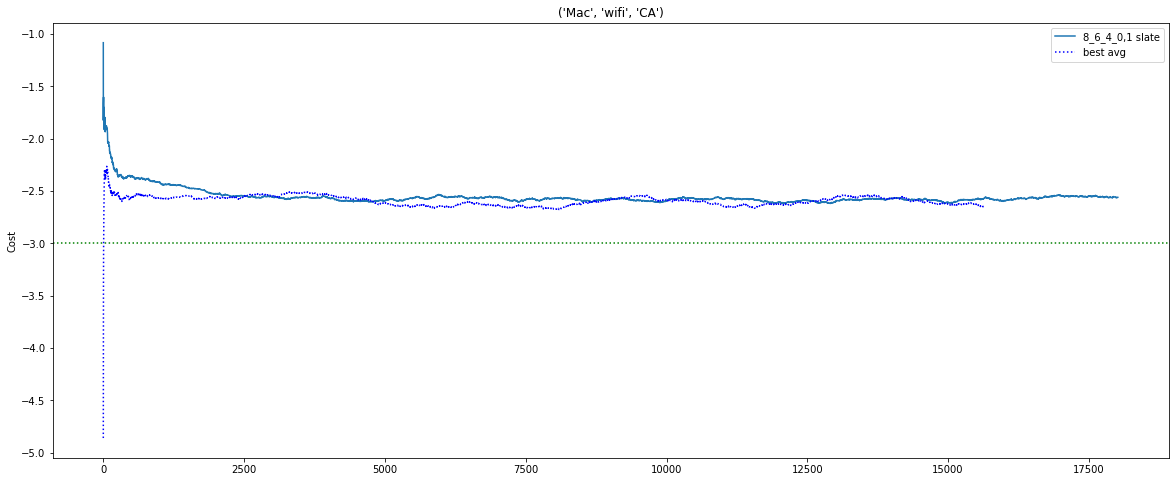

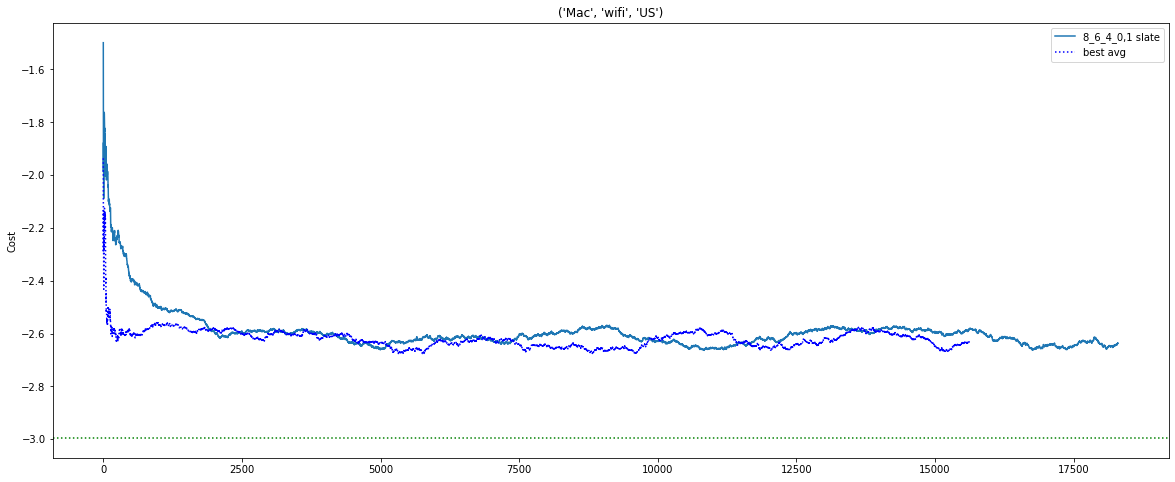

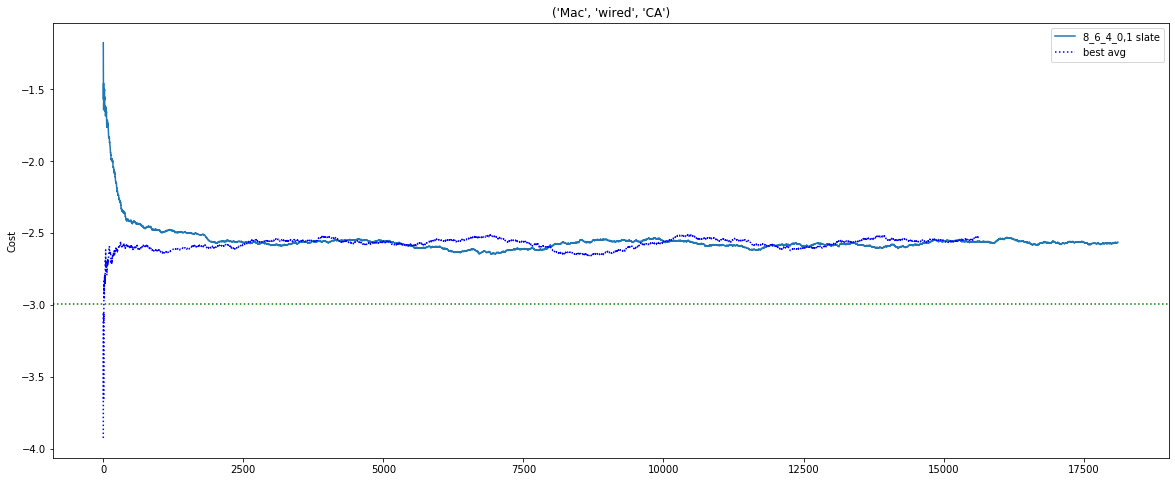

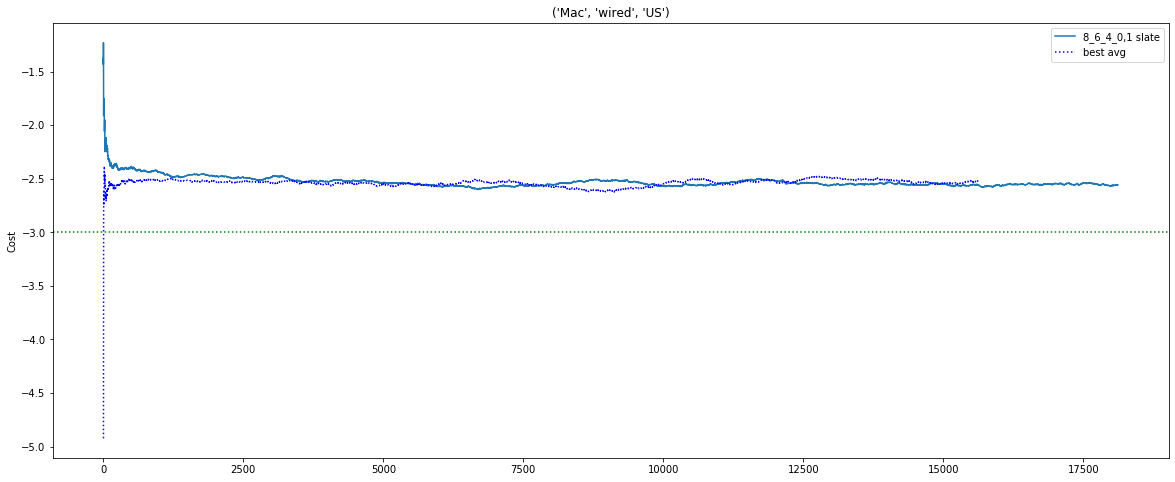

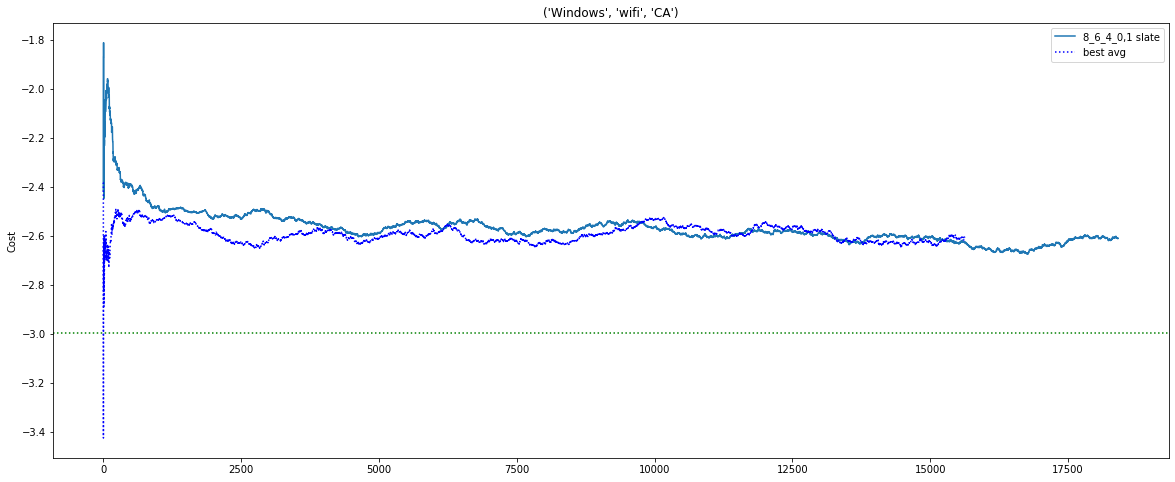

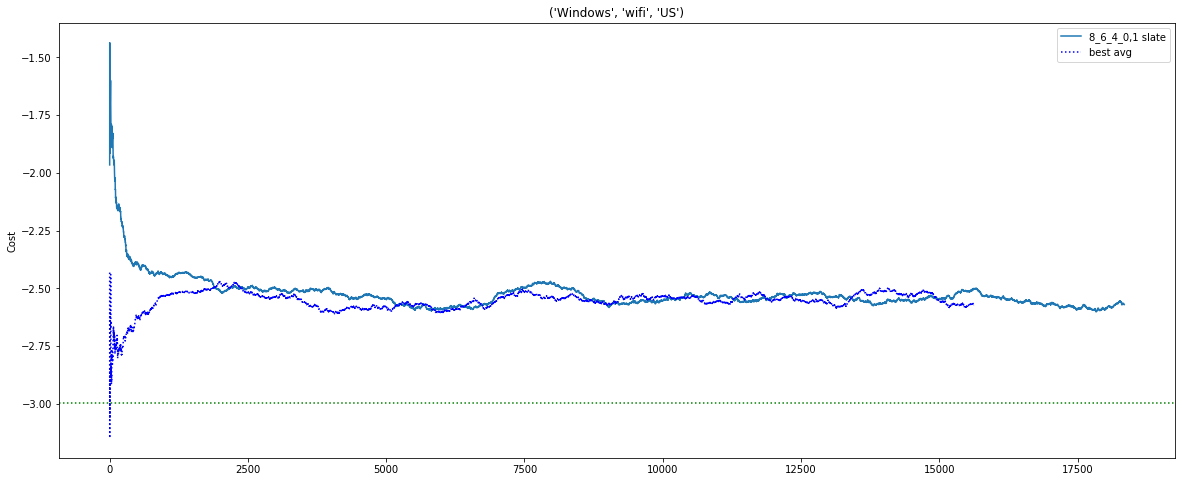

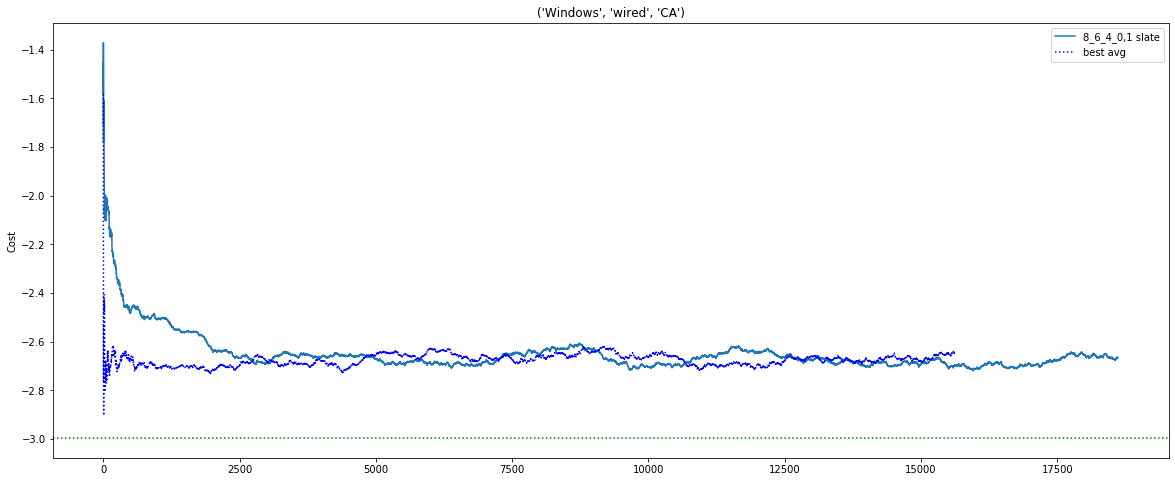

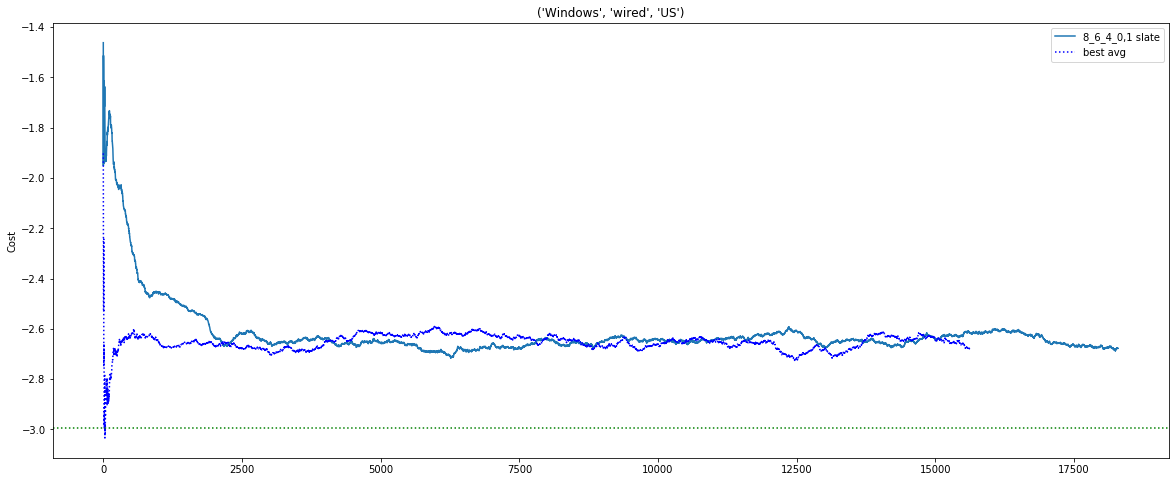

In [17]:
contexts = sorted(list(test_configs[next(iter(test_configs))]["outcomes"].keys()))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for context in contexts:
    plt.figure(figsize=(20, 8))
#     slates_trimmed = test_configs[name]["outcomes"][context] # All of them
#     cb_trimmed = test_configs[name]["cb_outcomes"][context]# All of them
#     number_of_samples = max(len(slates_trimmed), len(cb_trimmed))
    number_of_samples = int(num_iter / 16)
    for i, name in enumerate(test_configs):
        samples = test_configs[name]["outcomes"][context]
        window_size = int(len(samples) / 10)
        plt.plot(pd.Series(np.log(samples)).rolling(window_size, min_periods=0).mean(), color=colors[i], label="{} slate".format(name))
#         plt.plot(pd.Series(cb_trimmed).rolling(window_size, min_periods=0).mean(), color=cb_colors[i], label="{} combinatorial".format(name))
    
    plt.ylabel("Cost")
    # Plot optimal policy by sampling optimal policy number_of_samples times
    optimal_policy_results = [optimal_policy_sample(context, min_actions[context]) for i in range(number_of_samples)]
    plt.plot(pd.Series(np.log(optimal_policy_results)).rolling(int(number_of_samples/10), min_periods=0).mean(), color='b', linestyle=':', label="best avg")
#     plt.ylim(0.04,0.1)
    plt.axhline(y=np.log(0.05), color='g', linestyle=':')
    plt.title("{}".format(context))
    plt.legend(loc="upper right")
    plt.show()
 


In [ ]:

contexts = sorted(list(test_configs[next(iter(test_configs))]["outcomes"].keys()))

slate_colors = ['#004c97','#000097','#009797']
cb_colors = ['#ad0603', '#ad5b03', '#ad0355']

for context in contexts:
    for i, name in enumerate(test_configs):
        data = test_configs[name]["x_outcomes"][context]
        actions = sorted(np.unique(data))
        x_action_counts = [sum(value == action for value in data) for action in actions]
        plt.bar(np.arange(len(actions)), x_action_counts)
        plt.xticks(np.arange(len(actions)), actions)
        plt.title("{} - X".format(context))
        plt.show()
        
        data = test_configs[name]["y_outcomes"][context]
        actions = sorted(np.unique(data))
        x_action_counts = [sum(value == action for value in data) for action in actions]
        plt.bar(np.arange(len(actions)), x_action_counts, color='g')
        plt.xticks(np.arange(len(actions)), actions)
        plt.title("{} - Y".format(context))
        plt.show()
        
        data = test_configs[name]["z_outcomes"][context]
        actions = sorted(np.unique(data))
        x_action_counts = [sum(value == action for value in data) for action in actions]
        plt.bar(np.arange(len(actions)), x_action_counts, color='y')
        plt.xticks(np.arange(len(actions)), actions)
        plt.title("{} - Z".format(context))
        plt.show()
               

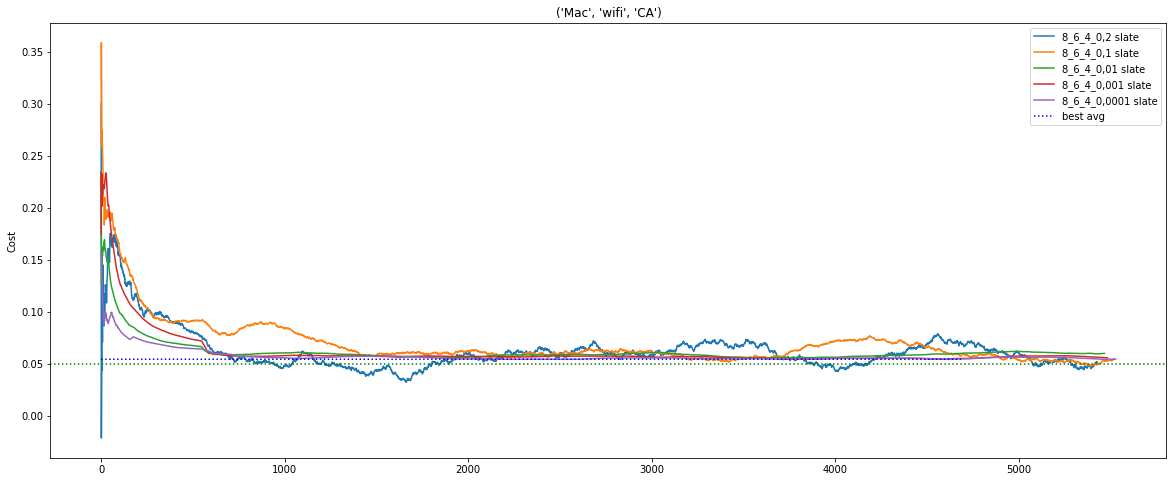

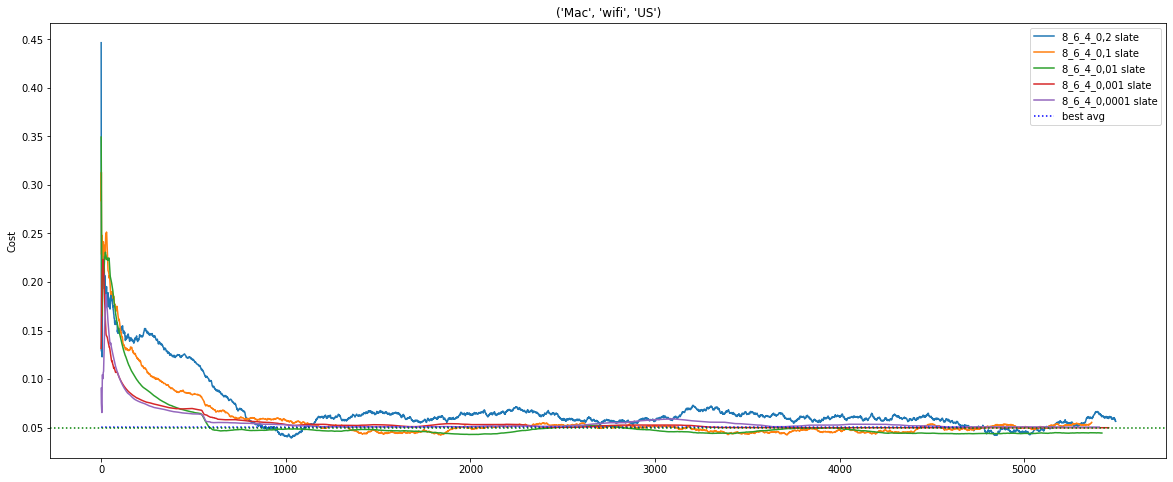

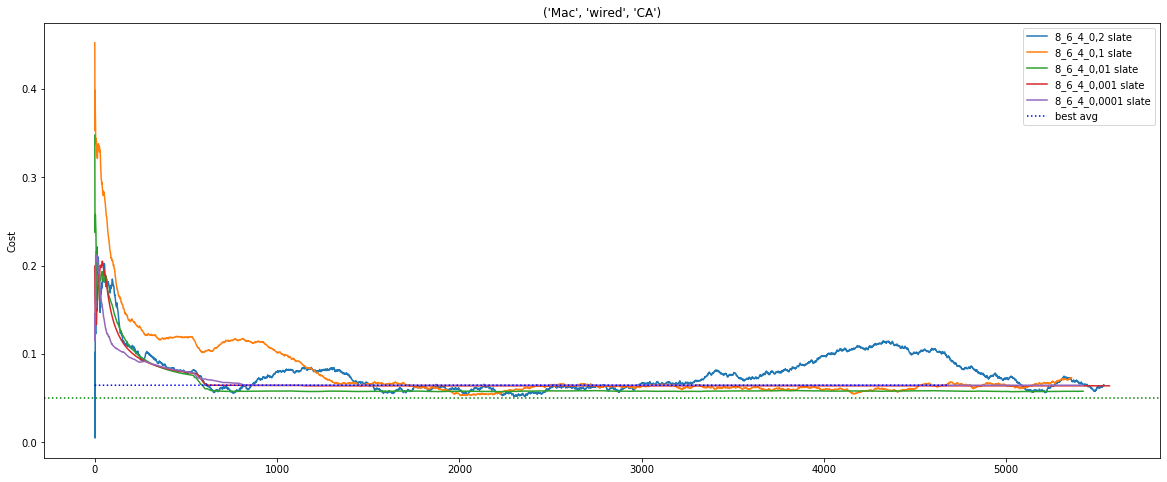

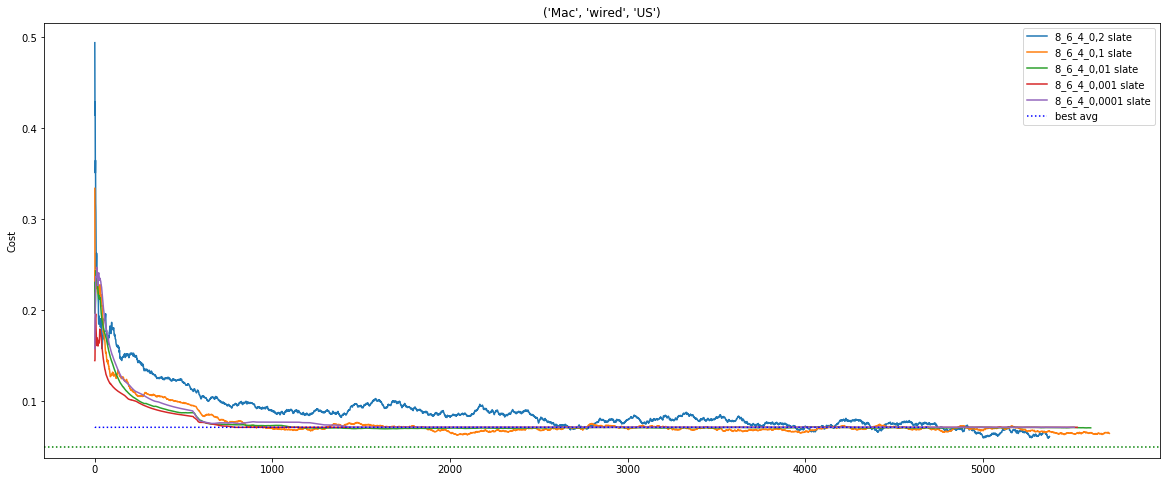

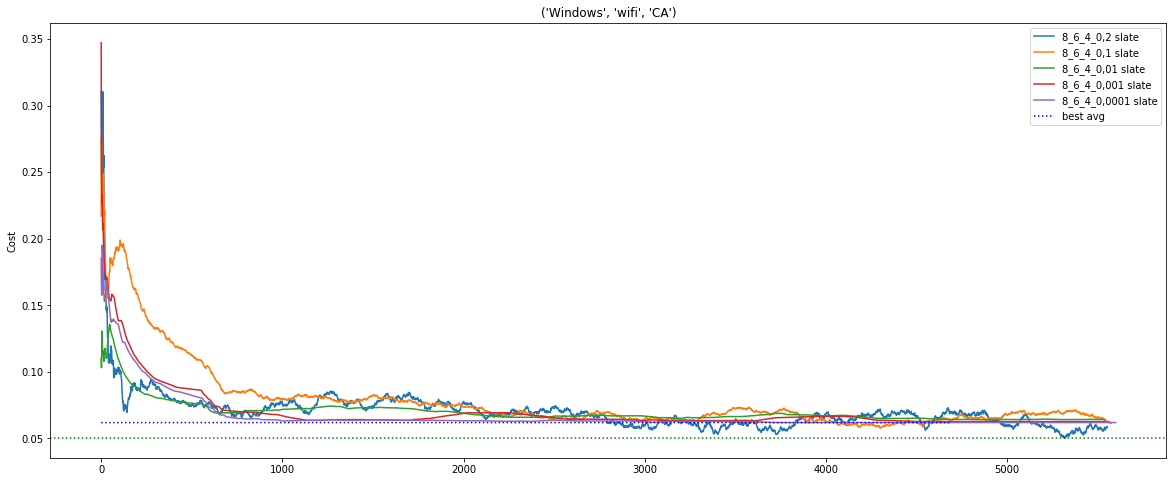

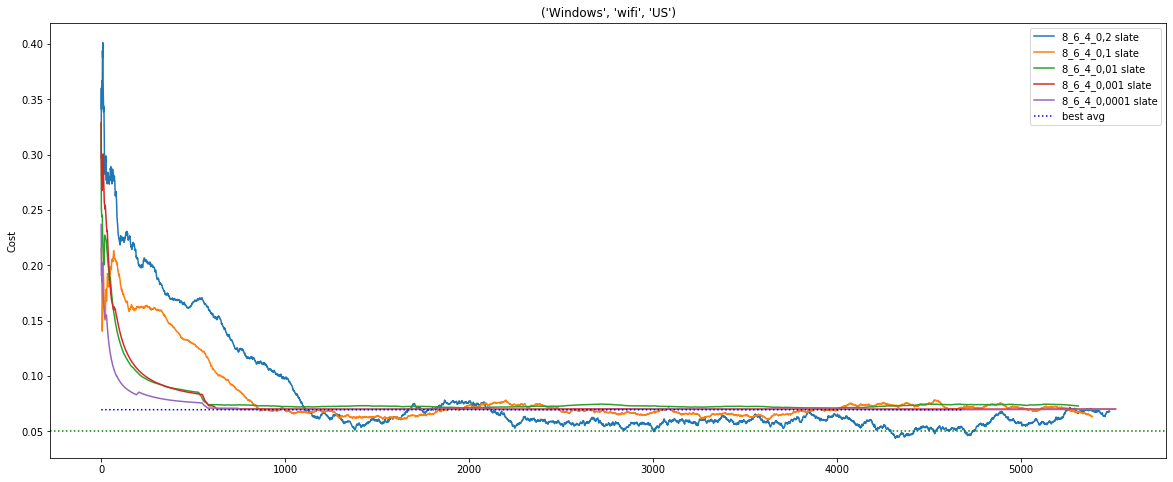

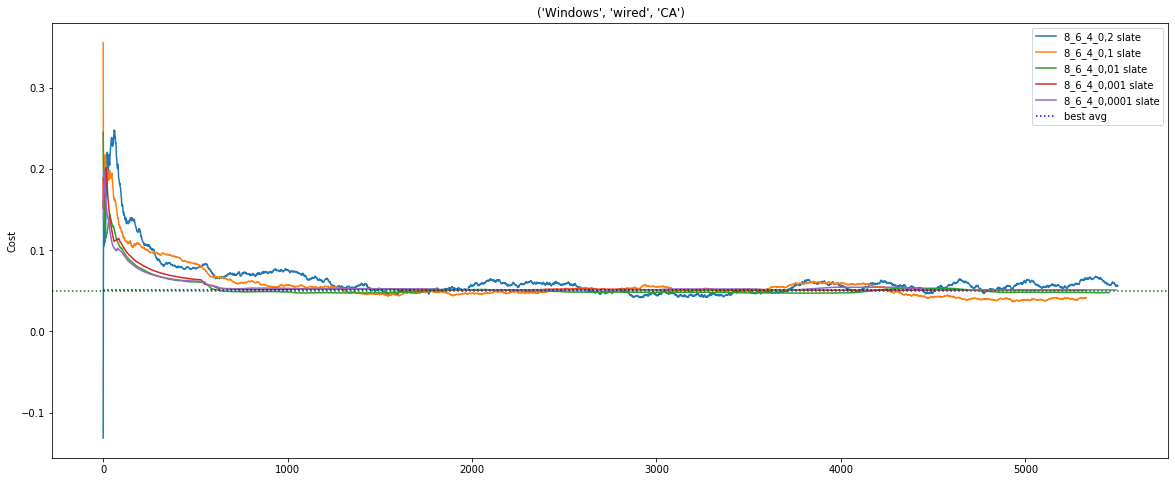

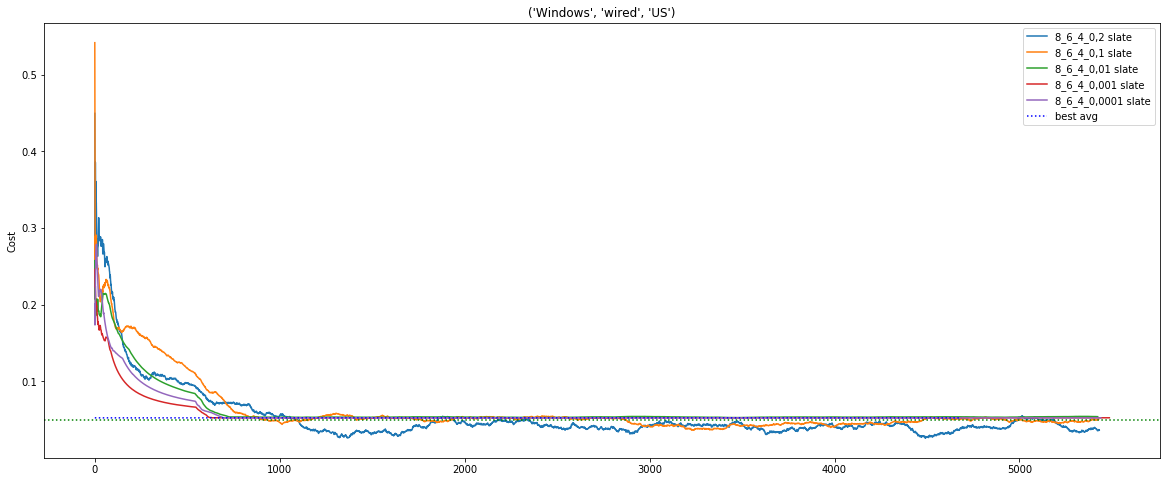

In [24]:
contexts = sorted(list(test_configs[next(iter(test_configs))]["outcomes"].keys()))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for context in contexts:
    plt.figure(figsize=(20, 8))
#     slates_trimmed = test_configs[name]["outcomes"][context] # All of them
#     cb_trimmed = test_configs[name]["cb_outcomes"][context]# All of them
#     number_of_samples = max(len(slates_trimmed), len(cb_trimmed))
    number_of_samples = int(num_iter / 16)
    for i, name in enumerate(test_configs):
        samples = test_configs[name]["outcomes"][context]
        window_size = int(len(samples) / 10)
        plt.plot(pd.Series(samples).rolling(window_size, min_periods=0).mean(), color=colors[i], label="{} slate".format(name))
#         plt.plot(pd.Series(cb_trimmed).rolling(window_size, min_periods=0).mean(), color=cb_colors[i], label="{} combinatorial".format(name))
    
    plt.ylabel("Cost")
    # Plot optimal policy by sampling optimal policy number_of_samples times
    optimal_policy_results = [optimal_policy_sample(context, min_actions[context]) for i in range(number_of_samples)]
    plt.plot(pd.Series(optimal_policy_results).rolling(120, min_periods=0).mean(), color='b', linestyle=':', label="best avg")
#     plt.ylim(0.04,0.1)
    plt.axhline(y=0.05, color='g', linestyle=':')
    plt.title("{}".format(context))
    plt.legend(loc="upper right")
    plt.show()
 